# This notebook contain all this three models 
Facial Recognition Model

Voiceprint Verification Model

Product Recommendation Model

# 1.Facial_recognition_model
This notebook script builds a facial recognition model using pre-extracted facial features from images.
It trains and compares three machine learning classifiers: Random Forest (with hyperparameter tuning),
Logistic Regression, and XGBoost. The script includes data cleaning, feature selection, and model evaluation
using accuracy, F1 score, and log loss. Results help identify which model performs best at recognizing individuals
based on their facial feature vectors.


Import Libraries

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, log_loss, make_scorer
import xgboost as xgb

In [30]:
print("=== Facial Recognition Model with Hyperparameter Tuning ===")

=== Facial Recognition Model with Hyperparameter Tuning ===


Load and clean the data

In [31]:
try:
    df = pd.read_csv('../image_features.csv')

    # Handle infinities and missing values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
except FileNotFoundError:
    print(" Error: '.../image_features.csv' not found.")
    exit()
except Exception as e:
    print(f" Error loading 'image_features.csv': {e}")
    exit()

Feature and target selection

In [32]:
feature_cols = [col for col in df.columns if col.startswith('bin_')]
if not feature_cols:
    print(" Error: No 'bin_' feature columns found.")
    exit()

X = df[feature_cols]
y = df['member']

if y.nunique() < 2:
    print(" Error: At least two unique member labels are required.")
    exit()

if y.value_counts().min() < 2:
    print(" Warning: Some classes have very few samples. Results may be unreliable.")

Train-test split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f" Data Split Complete — Training: {len(X_train)}, Test: {len(X_test)}")

 Data Split Complete — Training: 33, Test: 15


Random Forest with Hyperparameter Tuning 

In [34]:
print("\n Training Random Forest with GridSearchCV...")

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2]
}

scorer = make_scorer(f1_score, average='weighted', zero_division=0)

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring=scorer,
    cv=min(5, len(X_train) // y_train.nunique()),
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_


 Training Random Forest with GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


Evaluate

In [35]:
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)

print(" Random Forest Results:")
print("Best Parameters:", grid_rf.best_params_)
print("Test Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4))
print("Test F1 Score:", round(f1_score(y_test, y_pred_rf, average='weighted'), 4))
print("Test Log Loss:", round(log_loss(y_test, y_proba_rf), 4))


 Random Forest Results:
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50}
Test Accuracy: 0.8667
Test F1 Score: 0.8578
Test Log Loss: 0.2693


Logistic Regression

In [36]:
print("\n Training Logistic Regression...")

lr = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)

print(" Logistic Regression Results:")
print("Test Accuracy:", round(accuracy_score(y_test, y_pred_lr), 4))
print("Test F1 Score:", round(f1_score(y_test, y_pred_lr, average='weighted'), 4))
print("Test Log Loss:", round(log_loss(y_test, y_proba_lr), 4))



 Training Logistic Regression...
 Logistic Regression Results:
Test Accuracy: 0.8
Test F1 Score: 0.7673
Test Log Loss: 1.7774


XGBoost Classifier

In [37]:
print("\n Training XGBoost Classifier...")

# Encode labels for XGBoost
label_map = {label: idx for idx, label in enumerate(y.unique())}
y_train_enc = y_train.map(label_map)
y_test_enc = y_test.map(label_map)

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

xgb_model.fit(X_train, y_train_enc)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)

print(" XGBoost Results:")
print("Test Accuracy:", round(accuracy_score(y_test_enc, y_pred_xgb), 4))
print("Test F1 Score:", round(f1_score(y_test_enc, y_pred_xgb, average='weighted'), 4))
print("Test Log Loss:", round(log_loss(y_test_enc, y_proba_xgb), 4))


 Training XGBoost Classifier...
 XGBoost Results:
Test Accuracy: 0.7333
Test F1 Score: 0.6978
Test Log Loss: 0.6344


# 2.voice_verification_model

This model uses MFCC-based voice features to classify speakers based on their voiceprints. It includes data loading, preprocessing, feature engineering, model training (Random Forest, Logistic Regression, XGBoost), and performance evaluation.

Import Library

In [38]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, log_loss
from sklearn.preprocessing import LabelEncoder
import joblib


 Load Data

In [39]:
df = pd.read_csv("../audio_features.csv")  # Replace with your actual file path
print(df.head())


                  filename  mfcc_mean  rolloff_mean    energy
0         KG_25_Avenue.wav -23.892967   3483.395508  0.000100
1       KG_25_Avenue_3.wav -21.878180   3329.424716  0.000135
2  yes_approve_stretch.wav -27.027054   3524.677734  0.000040
3    yes_approve_pitch.wav -25.835110   4257.914062  0.000044
4    yes_approve_noise.wav -20.430970   8949.537598  0.000109


Define Training Function

In [40]:
def train_voice_model():
    df = pd.read_csv("../audio_features.csv")

    if 'filename' not in df.columns:
        raise KeyError("The 'filename' column is missing in audio_features.csv")

    # Extract label from filename
    df['label'] = df['filename'].apply(lambda x: os.path.basename(x).split('_')[0])

    # Encode label
    le = LabelEncoder()
    df['label'] = le.fit_transform(df['label'])

    # Features
    X = df.drop(columns=['filename', 'label'])

    # Convert object columns to numeric
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = LabelEncoder().fit_transform(X[col])

    y = df['label']

    # Smart split
    if len(df) >= len(le.classes_) * 5:
        stratify_option = y
        test_size = 0.3
    else:
        stratify_option = None
        test_size = 0.2

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=stratify_option
    )

    return X_train, X_test, y_train, y_test, le


Train and Evaluate Model

In [41]:
def train_and_evaluate(X_train, X_test, y_train, y_test, le):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    loss = log_loss(y_test, y_proba, labels=le.transform(le.classes_))

    print(f" Accuracy: {acc:.4f}")
    print(f" F1 Score: {f1:.4f}")
    print(f" Log Loss: {loss:.4f}")

    return model, y_pred


Plot Confusion Matrix

In [42]:
def plot_confusion(y_test, y_pred, le):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.title(" Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


Save Model

In [43]:
def save_model(model, le):
    os.makedirs("saved_models", exist_ok=True)
    joblib.dump(model, "saved_models/voice_model.pkl")
    joblib.dump(le, "saved_models/voice_label_encoder.pkl")
    print(" Voice model trained and saved successfully.")


Run Everything

 Accuracy: 0.5000
 F1 Score: 0.3333
 Log Loss: 0.8205


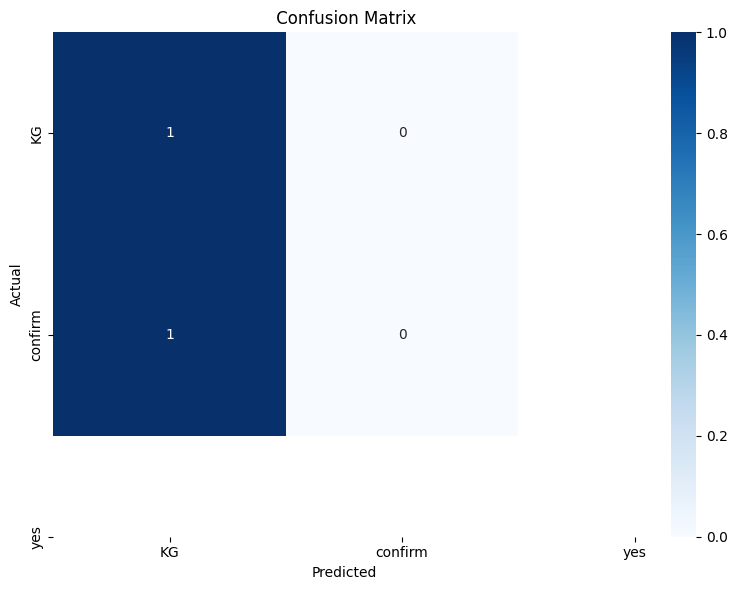

 Voice model trained and saved successfully.


In [44]:
X_train, X_test, y_train, y_test, le = train_voice_model()
model, y_pred = train_and_evaluate(X_train, X_test, y_train, y_test, le)
plot_confusion(y_test, y_pred, le)
save_model(model, le)


# 3.Product Recommendation Model

This notebook trains and evaluates machine learning models (Random Forest, Logistic Regression, and XGBoost) to classify products based on features from a merged customer dataset. It includes data loading, cleaning, splitting, model training with hyperparameter tuning, and performance evaluation.

Import Library

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings

warnings.filterwarnings('ignore')


Load and Clean Data

In [46]:
try:
    data_df = pd.read_csv("../merged_customer_data.csv", nrows=1000)
    data_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    data_df.dropna(inplace=True)
    print(f" Data loaded: {data_df.shape[0]} samples, {data_df.shape[1]} columns")
except FileNotFoundError:
    print(" Error: 'merged_customer_data.csv' not found.")
except Exception as e:
    print(f" Error loading dataset: {e}")


 Data loaded: 61 samples, 11 columns


Feature Selection and Splitting


In [47]:
# Features & target
X = data_df.drop(columns=["product_category"])
y = data_df["product_category"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Train the Model

In [48]:
# Prepare features
X = data_df.drop(columns=["product_category", "customer_id_new", "customer_id_legacy", "transaction_id", "purchase_date"])

# One-hot encode categorical variables
X = pd.get_dummies(X)

# Target
y = data_df["product_category"]


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Make Predictions & Evaluate

In [50]:
from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report

y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
loss = log_loss(y_test, y_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Log Loss: {loss:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.23
F1-Score: 0.21
Log Loss: 1.8403

Classification Report:
              precision    recall  f1-score   support

       Books       0.00      0.00      0.00         2
    Clothing       0.20      0.50      0.29         2
 Electronics       0.00      0.00      0.00         2
   Groceries       0.00      0.00      0.00         2
      Sports       0.50      0.40      0.44         5

    accuracy                           0.23        13
   macro avg       0.14      0.18      0.15        13
weighted avg       0.22      0.23      0.21        13



Check Class Distribution

In [51]:
print("Class Distribution:\n")
print(y.value_counts())


Class Distribution:

product_category
Sports         16
Electronics    15
Clothing       13
Books          11
Groceries       6
Name: count, dtype: int64


Feature Importance Plot

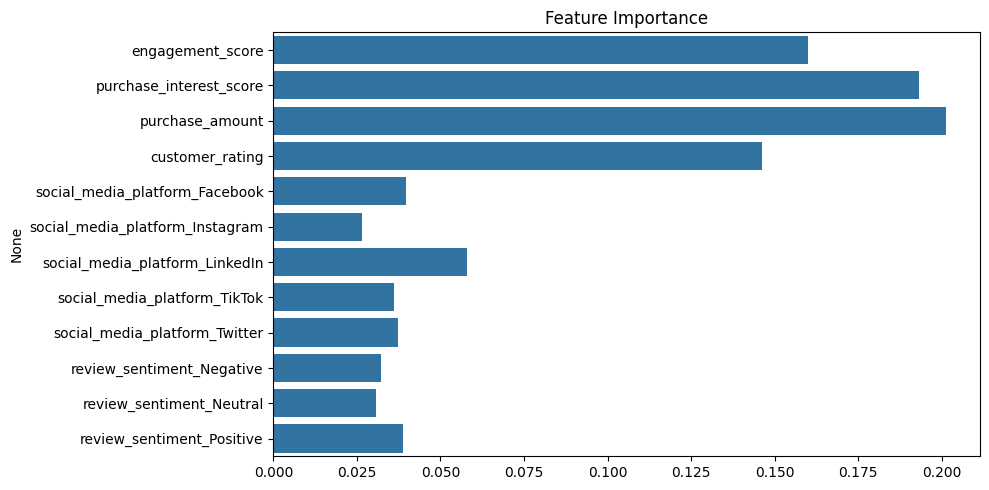

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = rf_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance, y=features)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()


In [53]:
print("=== Thank U ===")

=== Thank U ===
